# TASK: CHURN and MARKETING CAMPAIGN
# 1. Créez trois modèles de prédiction pour prédire le taux de désabonnement. La variable Si2014=0 identifie un désistement. Evaluez les trois modèles à l'aide des courbes ROC et de la distribution des probabilités de prédiction. (30 points)


# Importation des librairies

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import spacy
import warnings
import xgboost as xgb

from sklearn.model_selection import train_test_split,cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, PowerTransformer, QuantileTransformer,PolynomialFeatures
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, accuracy_score, confusion_matrix, classification_report

from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.feature_selection import SelectFromModel
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from scipy import stats
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

In [2]:
df = pd.read_csv('churn.csv')
df

,codcliente,si2014,ultimo_ing.x,abb13,abb14_renewed,importo,age,tenure,tipo_pag_ACQUISTO ON-LINE,tipo_pag_BANCOMAT,...,riduzione_ABBONAMENTO MUSEI BUONO,riduzione_ABBONAMENTO MUSEI OMAGGIO,riduzione_ABBONAMENTO MUSEI RIDOTTO,riduzione_ABBONAMENTO MUSEI su carte EDISU,riduzione_ABBONAMENTO RIDOTTO SCONTATO,riduzione_OFFERTA CONVENZIONE,riduzione_OFFERTA CONVENZIONE.1,riduzione_OFFERTA SU QUANTITATIVO,riduzione_OFFERTA SU QUANTITATIVO.1,riduzione_PASS 60 e VOUCHER OFFERTA
0,6,1,2013-10-27,2012-12-24,1,44,46,307,0,1,...,0,0,0,0,0,0,0,0,0,0
1,13,1,2013-11-24,2013-01-05,1,44,45,323,0,0,...,0,0,0,0,0,0,0,0,0,0
2,14,1,2013-01-10,2013-01-10,1,28,54,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,16,1,2014-01-03,2013-01-11,1,49,30,357,0,0,...,0,0,0,0,0,0,0,0,0,0
4,23,1,2013-12-21,2013-01-03,1,28,19,352,0,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80135,287273,1,2013-10-04,2012-12-20,1,30,48,288,0,0,...,0,0,0,0,0,0,0,1,0,0
80136,287274,1,2013-08-03,2012-12-20,1,44,45,226,0,0,...,0,0,0,0,0,0,0,0,1,0
80137,287275,0,2013-07-02,2012-12-19,0,30,86,195,0,0,...,0,0,1,0,0,0,0,0,0,0
80138,287277,0,2013-11-22,2012-12-09,0,28,27,348,0,1,...,0,0,0,0,1,0,0,0,0,0


In [3]:
df.columns.to_list()

['codcliente',
 'si2014',
 'ultimo_ing.x',
 'abb13',
 'abb14_renewed',
 'importo',
 'age',
 'tenure',
 'tipo_pag_ACQUISTO ON-LINE',
 'tipo_pag_BANCOMAT',
 'tipo_pag_CARTA DI CREDITO',
 'tipo_pag_CONTANTI',
 'tipo_pag_NESSUN PAGAMENTO',
 'Is_New_Customer',
 'sesso_F',
 'sesso_M',
 'sesso_Unknown',
 'riduzione_ABBONAMENTI MUSEI TORINO',
 'riduzione_ABBONAMENTO MUSEI BUONO',
 'riduzione_ABBONAMENTO MUSEI OMAGGIO',
 'riduzione_ABBONAMENTO MUSEI RIDOTTO',
 'riduzione_ABBONAMENTO MUSEI su carte EDISU',
 'riduzione_ABBONAMENTO RIDOTTO SCONTATO',
 'riduzione_OFFERTA CONVENZIONE',
 'riduzione_OFFERTA CONVENZIONE.1',
 'riduzione_OFFERTA SU QUANTITATIVO',
 'riduzione_OFFERTA SU QUANTITATIVO.1',
 'riduzione_PASS 60 e VOUCHER OFFERTA']

In [4]:
col_name = ['codcliente',
 'abb14_renewed',
 'importo',
 'age',
 'tenure',
 'tipo_pag_ACQUISTO ON-LINE',
 'tipo_pag_BANCOMAT',
 'tipo_pag_CARTA DI CREDITO',
 'tipo_pag_CONTANTI',
 'tipo_pag_NESSUN PAGAMENTO',
 'Is_New_Customer',
 'sesso_F',
 'sesso_M',
 'sesso_Unknown',
 'riduzione_ABBONAMENTI MUSEI TORINO',
 'riduzione_ABBONAMENTO MUSEI BUONO',
 'riduzione_ABBONAMENTO MUSEI OMAGGIO',
 'riduzione_ABBONAMENTO MUSEI RIDOTTO',
 'riduzione_ABBONAMENTO MUSEI su carte EDISU',
 'riduzione_ABBONAMENTO RIDOTTO SCONTATO',
 'riduzione_OFFERTA CONVENZIONE',
 'riduzione_OFFERTA CONVENZIONE.1',
 'riduzione_OFFERTA SU QUANTITATIVO',
 'riduzione_OFFERTA SU QUANTITATIVO.1',
 'riduzione_PASS 60 e VOUCHER OFFERTA']


# MODELISATION

In [18]:
def print_score(clf, X_train, y_train, X_test, y_test, train=True):
    if train:
        pred = clf.predict(X_train)
        clf_report = pd.DataFrame(classification_report(y_train, pred, output_dict=True))
        print("Train Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(y_train, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_train, pred)}\n")
        
    elif train==False:
        pred = clf.predict(X_test)
        clf_report = pd.DataFrame(classification_report(y_test, pred, output_dict=True))
        print("Test Result:\n================================================")        
        print(f"Accuracy Score: {accuracy_score(y_test, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_test, pred)}\n")

# We split the data into training and testing sets

In [120]:
X = df[col_name]
y = df['si2014']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [395]:
temp = X.drop(columns = 'abb14_renewed')
X_def = temp.drop(columns = 'codcliente')
X_train, X_test, y_train, y_test = train_test_split(X_def, y, test_size=0.2, random_state=42)

# 1. Logistic Regression

In [396]:
lr_clf = LogisticRegression(solver='liblinear')
lr_clf.fit(X_train, y_train)

print_score(lr_clf, X_train, y_train, X_test, y_test, train=True)
print_score(lr_clf, X_train, y_train, X_test, y_test, train=False)

Train Result:
Accuracy Score: 73.63%
_______________________________________________
CLASSIFICATION REPORT:
                      0             1  accuracy     macro avg  weighted avg
precision      0.610849      0.765359  0.736258      0.688104      0.718157
recall         0.376596      0.894466  0.736258      0.635531      0.736258
f1-score       0.465936      0.824892  0.736258      0.645414      0.715232
support    19586.000000  44526.000000  0.736258  64112.000000  64112.000000
_______________________________________________
Confusion Matrix: 
 [[ 7376 12210]
 [ 4699 39827]]

Test Result:
Accuracy Score: 73.56%
_______________________________________________
CLASSIFICATION REPORT:
                     0             1  accuracy     macro avg  weighted avg
precision     0.615360      0.764107  0.735588      0.689733      0.718196
recall        0.382252      0.893331  0.735588      0.637791      0.735588
f1-score      0.471571      0.823681  0.735588      0.647626      0.715003
suppo

In [397]:
test_score = accuracy_score(y_test, lr_clf.predict(X_test)) * 100
train_score = accuracy_score(y_train, lr_clf.predict(X_train)) * 100

results_df = pd.DataFrame(data=[["Logistic Regression", train_score, test_score]], 
                          columns=['Model', 'Training Accuracy %', 'Testing Accuracy %'])
results_df

,Model,Training Accuracy %,Testing Accuracy %
0,Logistic Regression,73.625842,73.558772


# 2. Decision Tree Classifier

In [398]:
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)

print_score(tree_clf, X_train, y_train, X_test, y_test, train=True)
print_score(tree_clf, X_train, y_train, X_test, y_test, train=False)

Train Result:
Accuracy Score: 93.57%
_______________________________________________
CLASSIFICATION REPORT:
                      0             1  accuracy     macro avg  weighted avg
precision      0.869470      0.967857  0.935737      0.918663      0.937800
recall         0.929133      0.938643  0.935737      0.933888      0.935737
f1-score       0.898312      0.953026  0.935737      0.925669      0.936311
support    19586.000000  44526.000000  0.935737  64112.000000  64112.000000
_______________________________________________
Confusion Matrix: 
 [[18198  1388]
 [ 2732 41794]]

Test Result:
Accuracy Score: 67.40%
_______________________________________________
CLASSIFICATION REPORT:
                     0             1  accuracy     macro avg  weighted avg
precision     0.473902      0.773594  0.674008      0.623748      0.681095
recall        0.510208      0.747135  0.674008      0.628671      0.674008
f1-score      0.491385      0.760134  0.674008      0.625760      0.677185
suppo

In [399]:
test_score = accuracy_score(y_test, tree_clf.predict(X_test)) * 100
train_score = accuracy_score(y_train, tree_clf.predict(X_train)) * 100

results_df_2 = pd.DataFrame(data=[["Decision Tree Classifier", train_score, test_score]], 
                          columns=['Model', 'Training Accuracy %', 'Testing Accuracy %'])
results_df = results_df.append(results_df_2, ignore_index=True)
results_df

,Model,Training Accuracy %,Testing Accuracy %
0,Logistic Regression,73.625842,73.558772
1,Decision Tree Classifier,93.573746,67.400799


# 3. Random Forest

In [400]:
rf_clf = RandomForestClassifier(n_estimators=1000, random_state=42)
rf_clf.fit(X_train, y_train)

print_score(rf_clf, X_train, y_train, X_test, y_test, train=True)
print_score(rf_clf, X_train, y_train, X_test, y_test, train=False)

Train Result:
Accuracy Score: 93.57%
_______________________________________________
CLASSIFICATION REPORT:
                      0             1  accuracy     macro avg  weighted avg
precision      0.927096      0.939138  0.935737      0.933117      0.935459
recall         0.857041      0.970354  0.935737      0.913698      0.935737
f1-score       0.890693      0.954491  0.935737      0.922592      0.935001
support    19586.000000  44526.000000  0.935737  64112.000000  64112.000000
_______________________________________________
Confusion Matrix: 
 [[16786  2800]
 [ 1320 43206]]

Test Result:
Accuracy Score: 69.99%
_______________________________________________
CLASSIFICATION REPORT:
                     0             1  accuracy     macro avg  weighted avg
precision     0.515736      0.768565    0.6999      0.642151      0.690530
recall        0.453810      0.809764    0.6999      0.631787      0.699900
f1-score      0.482796      0.788627    0.6999      0.635711      0.694233
suppo

In [401]:
test_score = accuracy_score(y_test, rf_clf.predict(X_test)) * 100
train_score = accuracy_score(y_train, rf_clf.predict(X_train)) * 100

results_df_2 = pd.DataFrame(data=[["Random Forest Classifier", train_score, test_score]], 
                          columns=['Model', 'Training Accuracy %', 'Testing Accuracy %'])
results_df = results_df.append(results_df_2, ignore_index=True)
results_df

,Model,Training Accuracy %,Testing Accuracy %
0,Logistic Regression,73.625842,73.558772
1,Decision Tree Classifier,93.573746,67.400799
2,Random Forest Classifier,93.573746,69.990017


# 4. XGBoost Classifer

In [402]:
xgb_clf = XGBClassifier(use_label_encoder=False)
xgb_clf.fit(X_train, y_train)

print_score(xgb_clf, X_train, y_train, X_test, y_test, train=True)
print_score(xgb_clf, X_train, y_train, X_test, y_test, train=False)

Train Result:
Accuracy Score: 77.45%
_______________________________________________
CLASSIFICATION REPORT:
                      0             1  accuracy     macro avg  weighted avg
precision      0.691258      0.796494  0.774488      0.743876      0.764344
recall         0.473144      0.907043  0.774488      0.690094      0.774488
f1-score       0.561773      0.848181  0.774488      0.704977      0.760684
support    19586.000000  44526.000000  0.774488  64112.000000  64112.000000
_______________________________________________
Confusion Matrix: 
 [[ 9267 10319]
 [ 4139 40387]]

Test Result:
Accuracy Score: 74.96%
_______________________________________________
CLASSIFICATION REPORT:
                     0             1  accuracy     macro avg  weighted avg
precision     0.637111      0.779987  0.749626      0.708549      0.735889
recall        0.438650      0.888458  0.749626      0.663554      0.749626
f1-score      0.519574      0.830697  0.749626      0.675135      0.734669
suppo

In [403]:
test_score = accuracy_score(y_test, xgb_clf.predict(X_test)) * 100
train_score = accuracy_score(y_train, xgb_clf.predict(X_train)) * 100

results_df_2 = pd.DataFrame(data=[["XGBoost Classifier", train_score, test_score]], 
                          columns=['Model', 'Training Accuracy %', 'Testing Accuracy %'])
results_df = results_df.append(results_df_2, ignore_index=True)
results_df

,Model,Training Accuracy %,Testing Accuracy %
0,Logistic Regression,73.625842,73.558772
1,Decision Tree Classifier,93.573746,67.400799
2,Random Forest Classifier,93.573746,69.990017
3,XGBoost Classifier,77.448840,74.962566


# 🤖 Models Hyperparameter Tuning

# 1. Logistic Regression Hyperparameter Tuning

In [250]:
temp = X.drop(columns = 'abb14_renewed')
X_def = temp.drop(columns = 'codcliente')
X_train, X_test, y_train, y_test = train_test_split(X_def, y, test_size=0.2, random_state=42)

param_grid = {
    'penalty': ['l1', 'l2'],
    'C': np.logspace(0, 6, 20),
    'solver': ['liblinear']
}

lr_clf = LogisticRegression()

lr_cv = GridSearchCV(lr_clf, param_grid, scoring="accuracy", n_jobs=1, verbose=1, cv=5)

lr_cv.fit(X_train, y_train)
best_params = lr_cv.best_params_
print(f"Best parameters: {best_params}")
lr_clf = LogisticRegression(**best_params)

lr_clf.fit(X_train, y_train)


print_score(lr_clf, X_train, y_train, X_test, y_test, train=True)
print_score(lr_clf, X_train, y_train, X_test, y_test, train=False)


Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best parameters: {'C': 162.3776739188721, 'penalty': 'l2', 'solver': 'liblinear'}
Train Result:
Accuracy Score: 73.64%
_______________________________________________
CLASSIFICATION REPORT:
                      0             1  accuracy     macro avg  weighted avg
precision      0.609145      0.766523  0.736352      0.687834      0.718445
recall         0.382263      0.892108  0.736352      0.637185      0.736352
f1-score       0.469743      0.824561  0.736352      0.647152      0.716165
support    19586.000000  44526.000000  0.736352  64112.000000  64112.000000
_______________________________________________
Confusion Matrix: 
 [[ 7487 12099]
 [ 4804 39722]]

Test Result:
Accuracy Score: 73.53%
_______________________________________________
CLASSIFICATION REPORT:
                     0             1  accuracy     macro avg  weighted avg
precision     0.612460      0.765080  0.735276      0.688770      0.717974
recall     

In [142]:
train_score = []
test_score = []

for c in np.logspace(0, 6, 20):
    model = LogisticRegression(C = c, penalty = 'l1', solver = 'liblinear')
    model.fit(X_train, y_train)
    train_score.append(accuracy_score(y_train, model.predict(X_train)))
    test_score.append(accuracy_score(y_test, model.predict(X_test)))

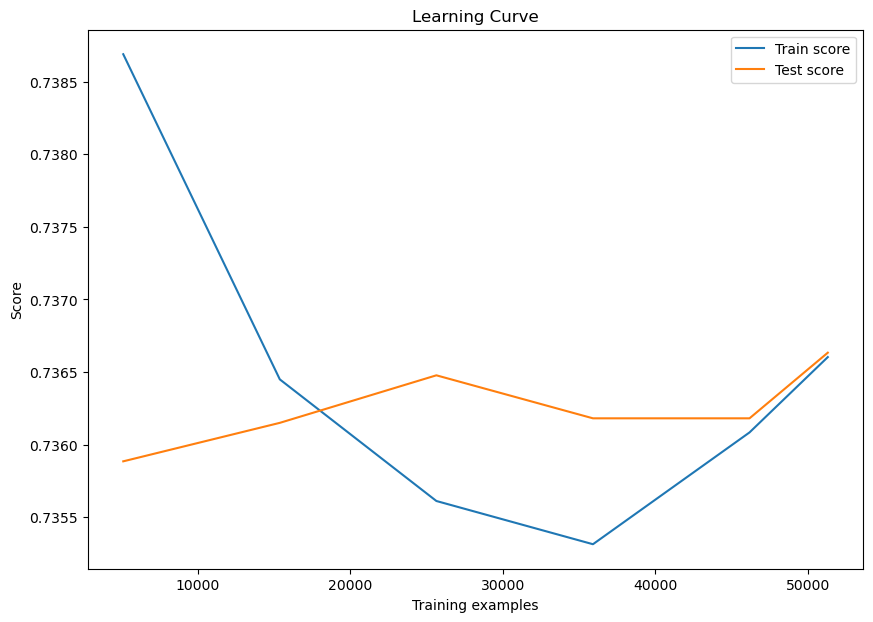

In [391]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(LogisticRegression(C = 162.3776739188721, penalty = 'l2', solver = 'liblinear'),
                                                        X_train, y_train, train_sizes=[0.1, 0.3, 0.5, 0.7, 0.9, 1], cv=5)

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(10, 7))
plt.plot(train_sizes, train_scores_mean, label='Train score')
plt.plot(train_sizes, test_scores_mean, label='Test score')
plt.xlabel('Training examples')
plt.ylabel('Score')
plt.title('Learning Curve')
plt.legend()
plt.show()


# 2. Decision Tree Classifier Hyperparameter Tuning

Fitting 3 folds for each of 4332 candidates, totalling 12996 fits
Best_params: {'criterion': 'entropy', 'max_depth': 8, 'min_samples_leaf': 4, 'min_samples_split': 2, 'splitter': 'best'}
Train Result:
Accuracy Score: 75.77%
_______________________________________________
CLASSIFICATION REPORT:
                      0             1  accuracy     macro avg  weighted avg
precision      0.665118      0.779619  0.757705      0.722369      0.744639
recall         0.416675      0.907717  0.757705      0.662196      0.757705
f1-score       0.512368      0.838805  0.757705      0.675587      0.739080
support    19586.000000  44526.000000  0.757705  64112.000000  64112.000000
_______________________________________________
Confusion Matrix: 
 [[ 8161 11425]
 [ 4109 40417]]

Test Result:
Accuracy Score: 74.69%
_______________________________________________
CLASSIFICATION REPORT:
                     0             1  accuracy     macro avg  weighted avg
precision     0.641810      0.772459   0.74

Text(0.5, 1.0, 'Importance des fonctionnalités pour DecisionTreeClassifier')

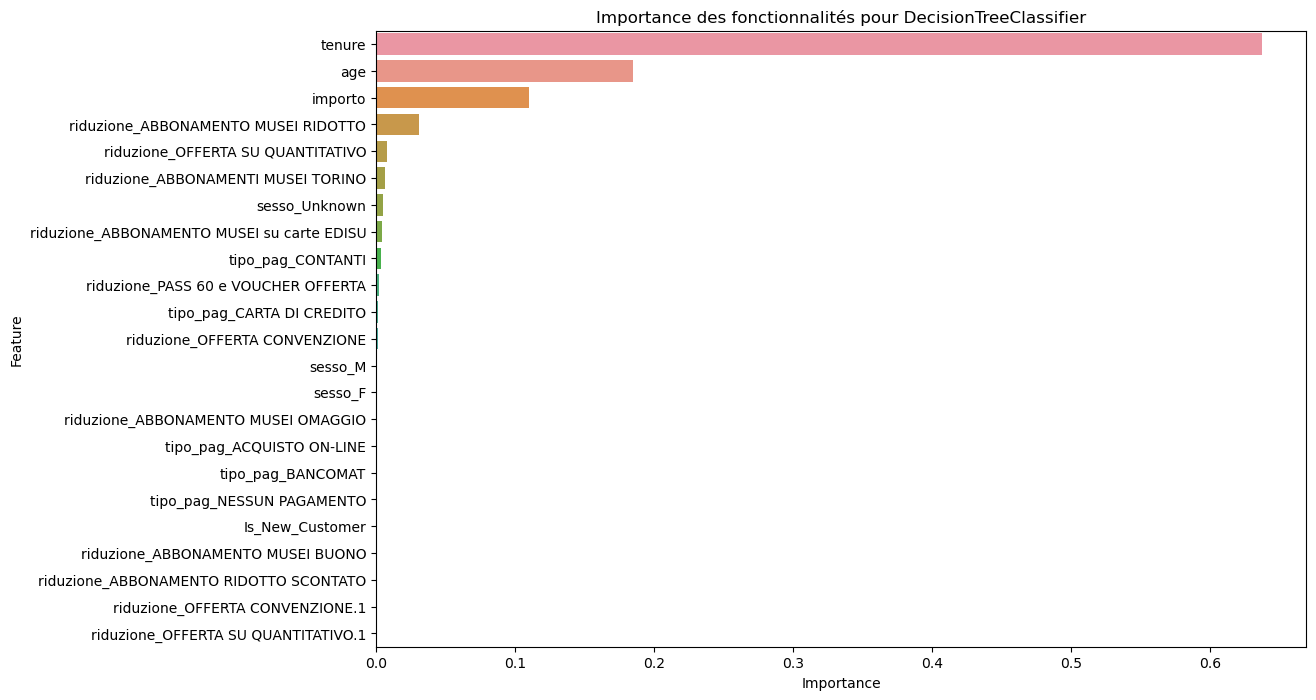

In [304]:

X_train, X_test, y_train, y_test = train_test_split(X_def, y, test_size=0.2, random_state=42)

params = {"criterion":("gini", "entropy"), 
          "splitter":("best", "random"), 
          "max_depth":(list(range(1, 20))), 
          "min_samples_split":[2, 3, 4], 
          "min_samples_leaf":list(range(1, 20))
          }

tree_clf = DecisionTreeClassifier(random_state=42)
tree_cv = GridSearchCV(tree_clf, params, scoring="accuracy", n_jobs=1, verbose=1, cv=3)
tree_cv.fit(X_train, y_train)
best_params = tree_cv.best_params_
print(f'Best_params: {best_params}')

tree_clf = DecisionTreeClassifier(**best_params)
tree_clf.fit(X_train, y_train)


# Obtenir l'importance des fonctionnalités
feature_importances = tree_clf.feature_importances_

# Créer un DataFrame pour visualiser l'importance des fonctionnalités
feature_importance_df = pd.DataFrame({'Feature': X_def.columns, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

print_score(tree_clf, X_train, y_train, X_test, y_test, train=True)
print_score(tree_clf, X_train, y_train, X_test, y_test, train=False)

# Tracer l'importance des fonctionnalités
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Importance des fonctionnalités pour DecisionTreeClassifier')

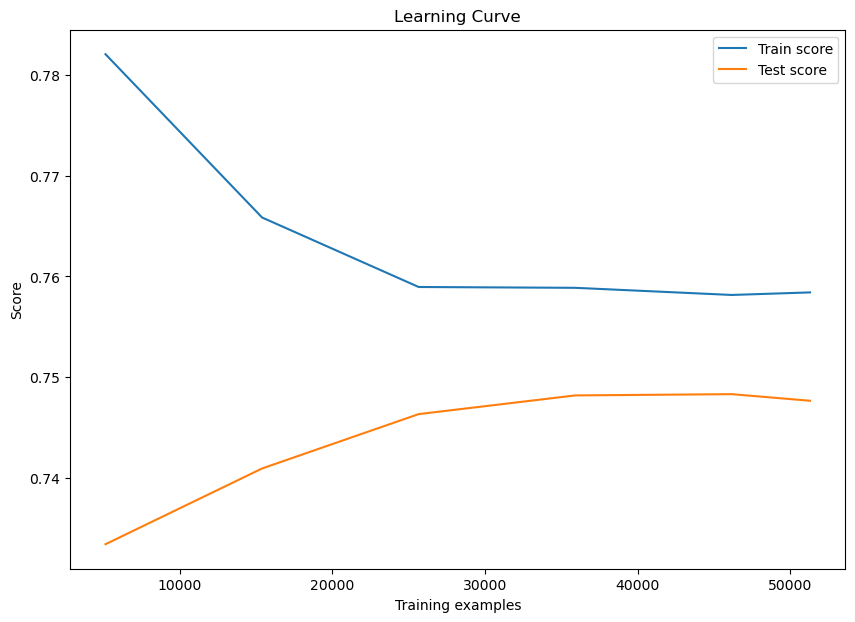

In [392]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(DecisionTreeClassifier(criterion = 'entropy', max_depth = 8, min_samples_leaf = 4, min_samples_split = 2, splitter = 'best',random_state=42),
                                                        X_train, y_train, train_sizes=[0.1, 0.3, 0.5, 0.7, 0.9, 1], cv=5)

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(10, 7))
plt.plot(train_sizes, train_scores_mean, label='Train score')
plt.plot(train_sizes, test_scores_mean, label='Test score')
plt.xlabel('Training examples')
plt.ylabel('Score')
plt.title('Learning Curve')
plt.legend()
plt.show()


Maximum score on the test data: 74.69%


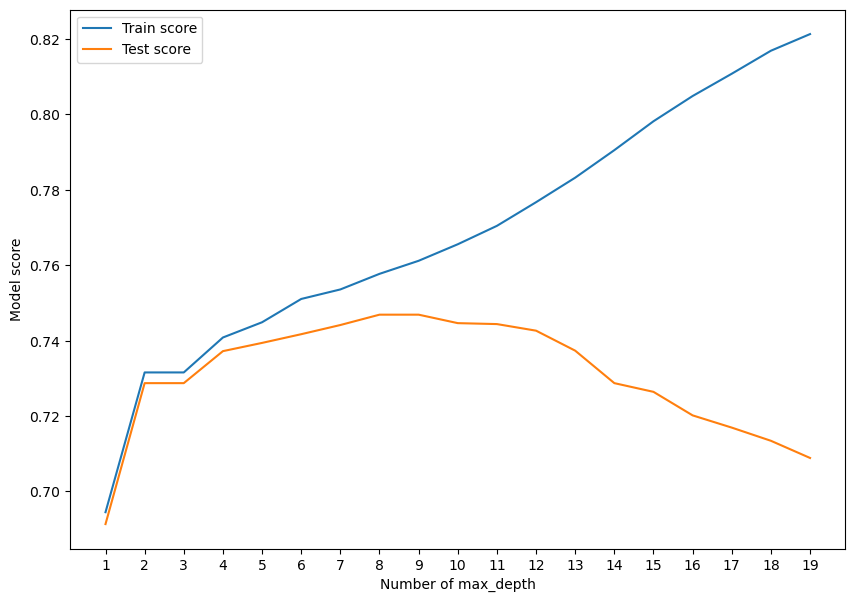

In [393]:
train_score = []
test_score = []
max_depth = list(range(1, 20))

for d in max_depth:
    model = DecisionTreeClassifier(criterion = 'entropy', max_depth = d, min_samples_leaf = 4, min_samples_split = 2, splitter = 'best',random_state=42)
    model.fit(X_train, y_train)
    train_score.append(accuracy_score(y_train, model.predict(X_train)))
    test_score.append(accuracy_score(y_test, model.predict(X_test)))
    
plt.figure(figsize=(10, 7))

plt.plot(max_depth, train_score, label="Train score")
plt.plot(max_depth, test_score, label="Test score")
plt.xticks(max_depth)
plt.xlabel("Number of max_depth")
plt.ylabel("Model score")
plt.legend()

print(f"Maximum score on the test data: {max(test_score)*100:.2f}%")

# 3. Random Forest Classifier Hyperparameter Tuning

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Best parameters: {'criterion': 'entropy', 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 111}
Train Result:
Accuracy Score: 77.20%
_______________________________________________
CLASSIFICATION REPORT:
                      0             1  accuracy     macro avg  weighted avg
precision      0.695160      0.791024  0.771993      0.743092      0.761738
recall         0.451751      0.912860  0.771993      0.682306      0.771993
f1-score       0.547626      0.847586  0.771993      0.697606      0.755950
support    19586.000000  44526.000000  0.771993  64112.000000  64112.000000
_______________________________________________
Confusion Matrix: 
 [[ 8848 10738]
 [ 3880 40646]]

Test Result:
Accuracy Score: 75.24%
_______________________________________________
CLASSIFICATION REPORT:
                     0             1  accuracy     macro avg  weighted avg
precision     0.65

Text(0.5, 1.0, 'Importance des fonctionnalités pour RandomForestClassifier')

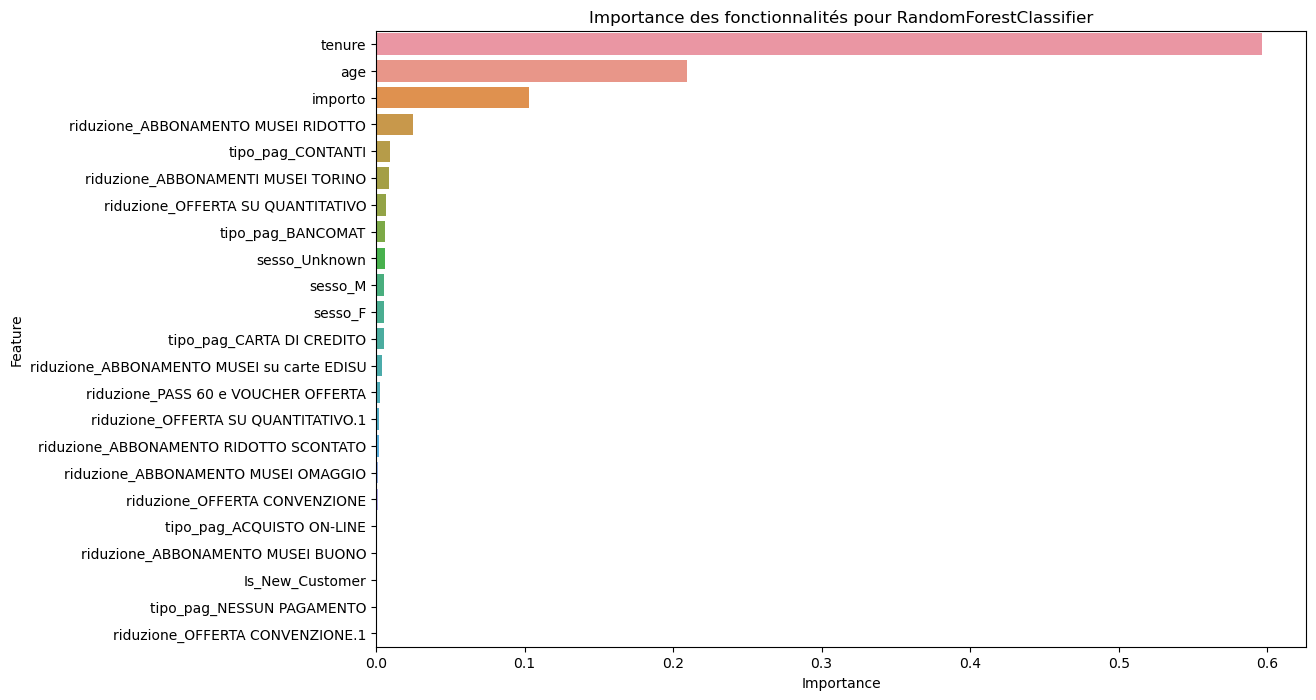

In [302]:


X_train, X_test, y_train, y_test = train_test_split(X_def, y, test_size=0.2, random_state=42)

params = {
    'n_estimators': randint(50, 200),
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 2, 3, 5, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

rf_clf = RandomForestClassifier(random_state=42)
rf_rand = RandomizedSearchCV(rf_clf, params, scoring="accuracy", cv=3, verbose=1, n_jobs=1, n_iter=100)
rf_rand.fit(X_train, y_train)

best_params = rf_rand.best_params_
print(f"Best parameters: {best_params}")

rf_clf = RandomForestClassifier(**best_params)
rf_clf.fit(X_train, y_train)


# Obtenir l'importance des fonctionnalités
feature_importances = rf_clf.feature_importances_

# Créer un DataFrame pour visualiser l'importance des fonctionnalités
feature_importance_df = pd.DataFrame({'Feature': X_def.columns, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

print_score(rf_clf, X_train, y_train, X_test, y_test, train=True)
print_score(rf_clf, X_train, y_train, X_test, y_test, train=False)

# Tracer l'importance des fonctionnalités
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Importance des fonctionnalités pour RandomForestClassifier')

Train Result:
Accuracy Score: 74.71%
_______________________________________________
CLASSIFICATION REPORT:
                      0             1  accuracy     macro avg  weighted avg
precision      0.611361      0.789063  0.747099      0.700212      0.734776
recall         0.472582      0.867852  0.747099      0.670217      0.747099
f1-score       0.533088      0.826585  0.747099      0.679836      0.736922
support    19586.000000  44526.000000  0.747099  64112.000000  64112.000000
_______________________________________________
Confusion Matrix: 
 [[ 9256 10330]
 [ 5884 38642]]

Test Result:
Accuracy Score: 74.43%
_______________________________________________
CLASSIFICATION REPORT:
                     0             1  accuracy     macro avg  weighted avg
precision     0.608818      0.787911  0.744322      0.698365      0.732635
recall        0.480089      0.862287  0.744322      0.671188      0.744322
f1-score      0.536844      0.823423  0.744322      0.680134      0.734971
suppo

Text(0.5, 1.0, 'Importance des fonctionnalités pour RandomForestClassifier')

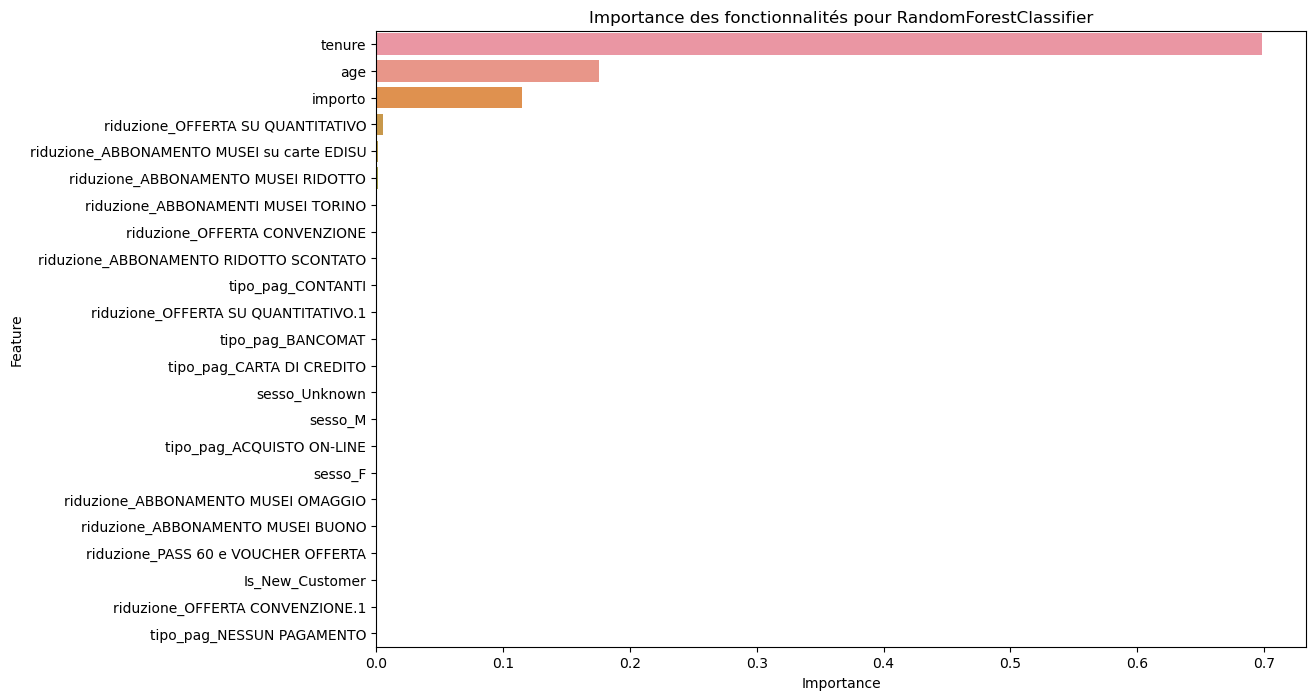

In [247]:
temp = X.drop(columns = 'abb14_renewed')
X_def = temp.drop(columns = 'codcliente')

X_train, X_test, y_train, y_test = train_test_split(X_def, y, test_size=0.2, random_state=42)

rf_clf = RandomForestClassifier(n_estimators=111, criterion='entropy', max_depth=10, min_samples_split=2, min_samples_leaf=4, max_features=None, random_state=42)
rf_clf.fit(X_train, y_train)


# Obtenir l'importance des fonctionnalités
feature_importances = rf_clf.feature_importances_

# Créer un DataFrame pour visualiser l'importance des fonctionnalités
feature_importance_df = pd.DataFrame({'Feature': X_def.columns, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

print_score(rf_clf, X_train, y_train, X_test, y_test, train=True)
print_score(rf_clf, X_train, y_train, X_test, y_test, train=False)

# Tracer l'importance des fonctionnalités
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Importance des fonctionnalités pour RandomForestClassifier')

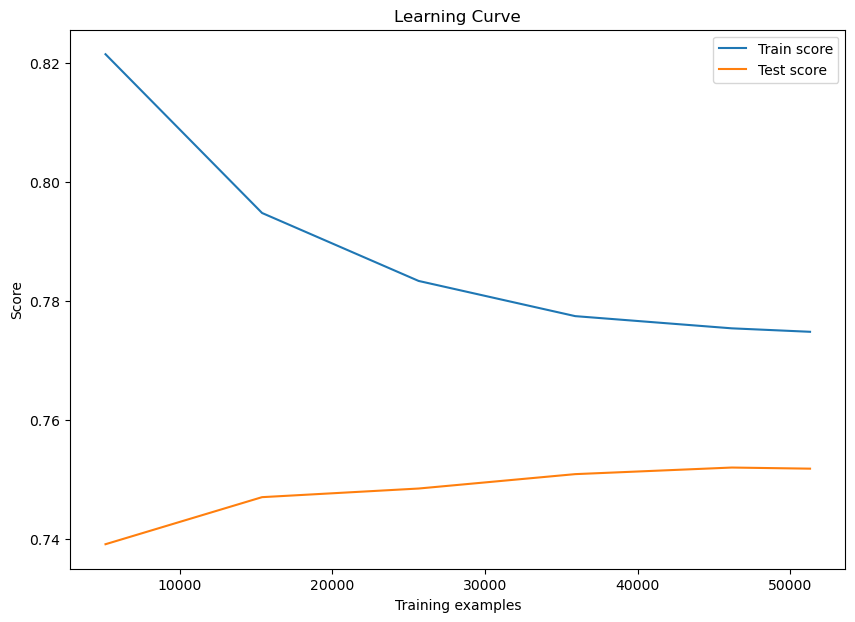

In [390]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(RandomForestClassifier(n_estimators=111, criterion='entropy', max_depth=10, min_samples_split=2, min_samples_leaf=4, max_features=None, random_state=42),
                                                        X_train, y_train, train_sizes=[0.1, 0.3, 0.5, 0.7, 0.9, 1], cv=5)

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(10, 7))
plt.plot(train_sizes, train_scores_mean, label='Train score')
plt.plot(train_sizes, test_scores_mean, label='Test score')
plt.xlabel('Training examples')
plt.ylabel('Score')
plt.title('Learning Curve')
plt.legend()
plt.show()

# 4. XGBoost Classifier Hyperparameter Tuning

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best paramters: {'learning_rate': 0.1761911094046562, 'max_depth': 2, 'n_estimators': 281}
Train Result:
Accuracy Score: 75.65%
_______________________________________________
CLASSIFICATION REPORT:
                      0             1  accuracy     macro avg  weighted avg
precision      0.654850      0.781949  0.756504      0.718400      0.743121
recall         0.429133      0.900508  0.756504      0.664820      0.756504
f1-score       0.518491      0.837051  0.756504      0.677771      0.739732
support    19586.000000  44526.000000  0.756504  64112.000000  64112.000000
_______________________________________________
Confusion Matrix: 
 [[ 8405 11181]
 [ 4430 40096]]

Test Result:
Accuracy Score: 75.32%
_______________________________________________
CLASSIFICATION REPORT:
                     0             1  accuracy     macro avg  weighted avg
precision     0.650288      0.779829  0.753182      0.715058      0.739846
re

Text(0.5, 1.0, 'Importance des fonctionnalités pour XGBClassifier')

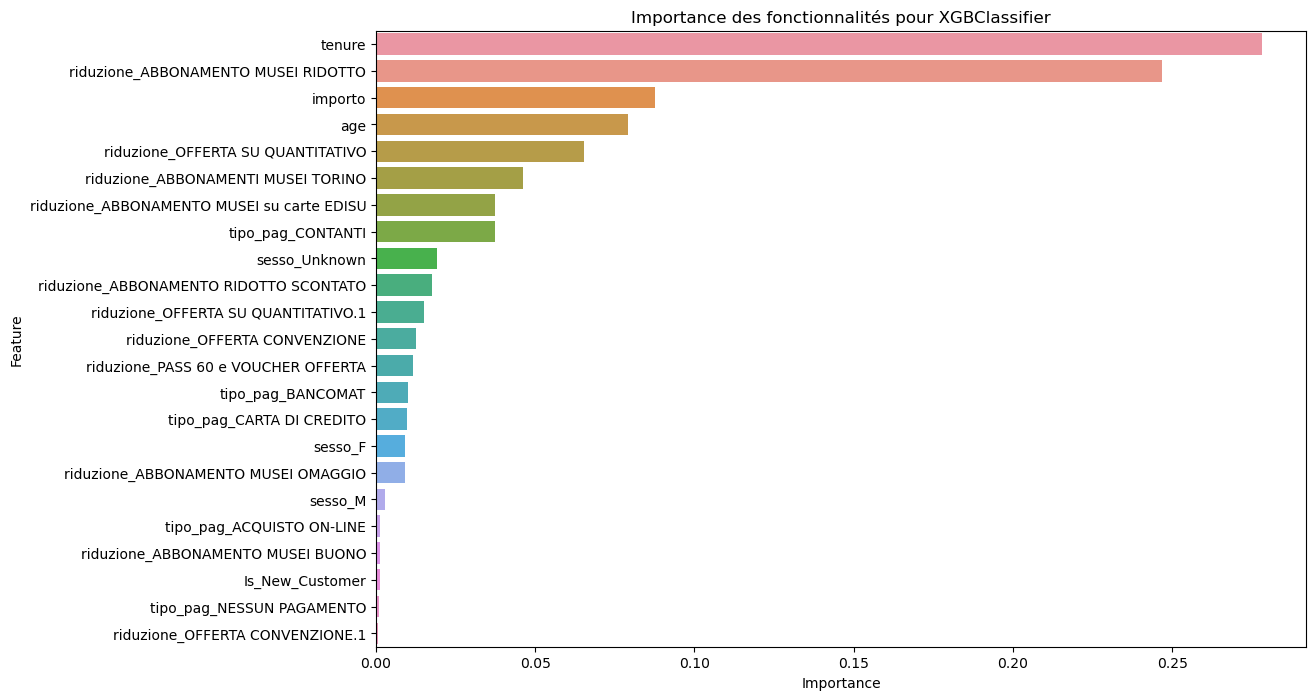

In [256]:
temp = X.drop(columns = 'abb14_renewed')
X_def = temp.drop(columns = 'codcliente')

X_train, X_test, y_train, y_test = train_test_split(X_def, y, test_size=0.2, random_state=42)

param_grid = dict(
    n_estimators=stats.randint(10, 1000),
    max_depth=stats.randint(1, 10),
    learning_rate=stats.uniform(0, 1)
)

xgb_clf = XGBClassifier(use_label_encoder=False)
xgb_cv = RandomizedSearchCV(
    xgb_clf, param_grid, cv=3, n_iter=50, 
    scoring='accuracy', n_jobs=1, verbose=1
)
xgb_cv.fit(X_train, y_train)
best_params = xgb_cv.best_params_
print(f"Best paramters: {best_params}")

xgb_clf = XGBClassifier(**best_params)
xgb_clf.fit(X_train, y_train)

# Obtenir l'importance des fonctionnalités
feature_importances = xgb_clf.feature_importances_

# Créer un DataFrame pour visualiser l'importance des fonctionnalités
feature_importance_df = pd.DataFrame({'Feature': X_def.columns, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

print_score(xgb_clf, X_train, y_train, X_test, y_test, train=True)
print_score(xgb_clf, X_train, y_train, X_test, y_test, train=False)

# Tracer l'importance des fonctionnalités
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Importance des fonctionnalités pour XGBClassifier')

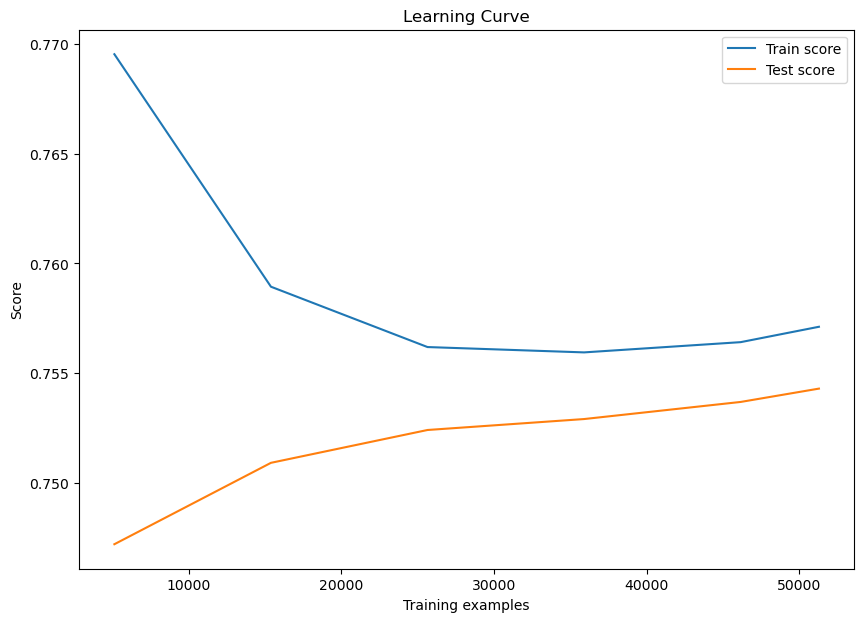

In [389]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(XGBClassifier(n_estimators = 281, max_depth = 2, learning_rate = 0.1761911094046562, use_label_encoder=False),
                                                        X_train, y_train, train_sizes=[0.1, 0.3, 0.5, 0.7, 0.9, 1], cv=5)

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(10, 7))
plt.plot(train_sizes, train_scores_mean, label='Train score')
plt.plot(train_sizes, test_scores_mean, label='Test score')
plt.xlabel('Training examples')
plt.ylabel('Score')
plt.title('Learning Curve')
plt.legend()
plt.show()


# CHOIX DU MEILLEUR MODELE EN COMPARANT LES ERREURS ET EN APPLIQUANT PLUSIEURS SCALER

In [306]:
# Initialiser les modèles que vous souhaitez tester
models = [
    ('LogisticRegression',LogisticRegression(penalty = 'l2', C = 162.3776739188721, solver = 'liblinear')),
    ('DecisionTreeClassifier',DecisionTreeClassifier(criterion = 'entropy', max_depth = 8, min_samples_leaf = 4, min_samples_split = 2, splitter = 'best',random_state=42)),
    ('RandomForest', RandomForestClassifier(n_estimators=111, criterion='entropy', max_depth=10, min_samples_split=2, min_samples_leaf=4, max_features=None, random_state=42)),
    ('XGBClassifier', XGBClassifier(n_estimators = 281, max_depth = 2, learning_rate = 0.1761911094046562, use_label_encoder=False))
]

# Initialiser les scalers que vous souhaitez tester
scalers = [
    ('StandardScaler', StandardScaler()),
    ('MinMaxScaler', MinMaxScaler()),
    ('RobustScaler', RobustScaler()),
    ('QuantileTransformer', QuantileTransformer())
]


In [307]:
# Dictionnaire pour stocker les résultats
results = {}
X = df[col_name]
y = df['si2014']
temp = X.drop(columns = 'abb14_renewed')
X_def = temp.drop(columns = 'codcliente')
X_train, X_test, y_train, y_test = train_test_split(X_def, y, test_size=0.2, random_state=42)

# Boucle sur les modèles
for model_name, model in models:
    # Boucle sur les scalers
    for scaler_name, scaler in scalers:
        X_train, X_test, y_train, y_test = train_test_split(X_def, y, test_size=0.2, random_state=42)

        # Appliquer le scaler aux données d'entraînement
        X_train_scaled = scaler.fit_transform(X_train)
        
        # Appliquer le scaler aux données de test (NE PAS réajuster le scaler sur les données de test)
        X_test_scaled = scaler.transform(X_test)
        
        # Adapter le modèle sur les données d'entraînement
        model.fit(X_train_scaled, y_train)
        
        # Prédire sur les données de test
        y_pred = model.predict(X_test_scaled)

        # Calculer les erreurs
        mae = mean_absolute_error(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        
        # Enregistrer les résultats
        key = f"{model_name} with {scaler_name}"
        results[key] = {
            'model': model_name,
            'scaler': scaler_name,
            'mae': mae,
            'mse': mse,
            'rmse': rmse
        }

# Trouver le modèle avec la plus petite MAE
best_model_mae = min(results, key=lambda x: results[x]['mae'])
best_mae_value = results[best_model_mae]['mae']

# Trouver le modèle avec la plus petite MSE
best_model_mse = min(results, key=lambda x: results[x]['mse'])
best_mse_value = results[best_model_mse]['mse']

# Trouver le modèle avec la plus petite RMSE
best_model_rmse = min(results, key=lambda x: results[x]['rmse'])
best_rmse_value = results[best_model_rmse]['rmse']

# Afficher les résultats du meilleur modèle pour chaque métrique
print(f"Meilleur modèle MAE : {best_model_mae}, MAE : {best_mae_value}")
print(f"Meilleur modèle MSE : {best_model_mse}, MSE : {best_mse_value}")
print(f"Meilleur modèle RMSE : {best_model_rmse}, RMSE : {best_rmse_value}")

# Sélectionner le modèle avec le score global le plus bas (somme des métriques)
best_model_key = min(results, key=lambda x: results[x]['mae'] + results[x]['mse'] + results[x]['rmse'])
best_model_name = results[best_model_key]['model']

# Afficher les résultats du meilleur modèle global
print(f"Meilleur modèle global : {best_model_name}")



Meilleur modèle MAE : XGBClassifier with StandardScaler, MAE : 0.2468180683803344
Meilleur modèle MSE : XGBClassifier with StandardScaler, MSE : 0.2468180683803344
Meilleur modèle RMSE : XGBClassifier with StandardScaler, RMSE : 0.49680787874221
Meilleur modèle global : XGBClassifier


In [308]:
# Choisir la métrique à utiliser pour le classement (MAE, MSE, RMSE)
metric_to_rank = 'mae'  # Remplacez par la métrique de votre choix

# Trier les résultats en fonction de la métrique sélectionnée
sorted_results = sorted(results.items(), key=lambda x: x[1][metric_to_rank])

# Afficher le classement
print(f"Classement en fonction de la métrique {metric_to_rank} :")
for rank, (model_key, metrics) in enumerate(sorted_results, 1):
    model_name = metrics['model']
    model_scaler = metrics['scaler']
    metric_value = metrics[metric_to_rank]
    print(f"{rank}. Modèle : {model_name}, {metric_to_rank}, {model_scaler}  : {metric_value}")


Classement en fonction de la métrique mae :
1. Modèle : XGBClassifier, mae, StandardScaler  : 0.2468180683803344
2. Modèle : XGBClassifier, mae, MinMaxScaler  : 0.2468180683803344
3. Modèle : XGBClassifier, mae, RobustScaler  : 0.2468180683803344
4. Modèle : RandomForest, mae, MinMaxScaler  : 0.24837783878213127
5. Modèle : RandomForest, mae, RobustScaler  : 0.24837783878213127
6. Modèle : RandomForest, mae, StandardScaler  : 0.24844022959820314
7. Modèle : RandomForest, mae, QuantileTransformer  : 0.24844022959820314
8. Modèle : XGBClassifier, mae, QuantileTransformer  : 0.248502620414275
9. Modèle : LogisticRegression, mae, QuantileTransformer  : 0.2530571499875218
10. Modèle : DecisionTreeClassifier, mae, StandardScaler  : 0.2531195408035937
11. Modèle : DecisionTreeClassifier, mae, MinMaxScaler  : 0.2531195408035937
12. Modèle : DecisionTreeClassifier, mae, RobustScaler  : 0.2531195408035937
13. Modèle : DecisionTreeClassifier, mae, QuantileTransformer  : 0.2531195408035937
14. Mod

In [309]:
# Convertir le dictionnaire de résultats en DataFrame
results_df = pd.DataFrame.from_dict(results, orient='index')

# Afficher le tableau
print(results_df)


                                                                  model  \
LogisticRegression with StandardScaler               LogisticRegression   
LogisticRegression with MinMaxScaler                 LogisticRegression   
LogisticRegression with RobustScaler                 LogisticRegression   
LogisticRegression with QuantileTransformer          LogisticRegression   
DecisionTreeClassifier with StandardScaler       DecisionTreeClassifier   
DecisionTreeClassifier with MinMaxScaler         DecisionTreeClassifier   
DecisionTreeClassifier with RobustScaler         DecisionTreeClassifier   
DecisionTreeClassifier with QuantileTransformer  DecisionTreeClassifier   
RandomForest with StandardScaler                           RandomForest   
RandomForest with MinMaxScaler                             RandomForest   
RandomForest with RobustScaler                             RandomForest   
RandomForest with QuantileTransformer                      RandomForest   
XGBClassifier with Standa

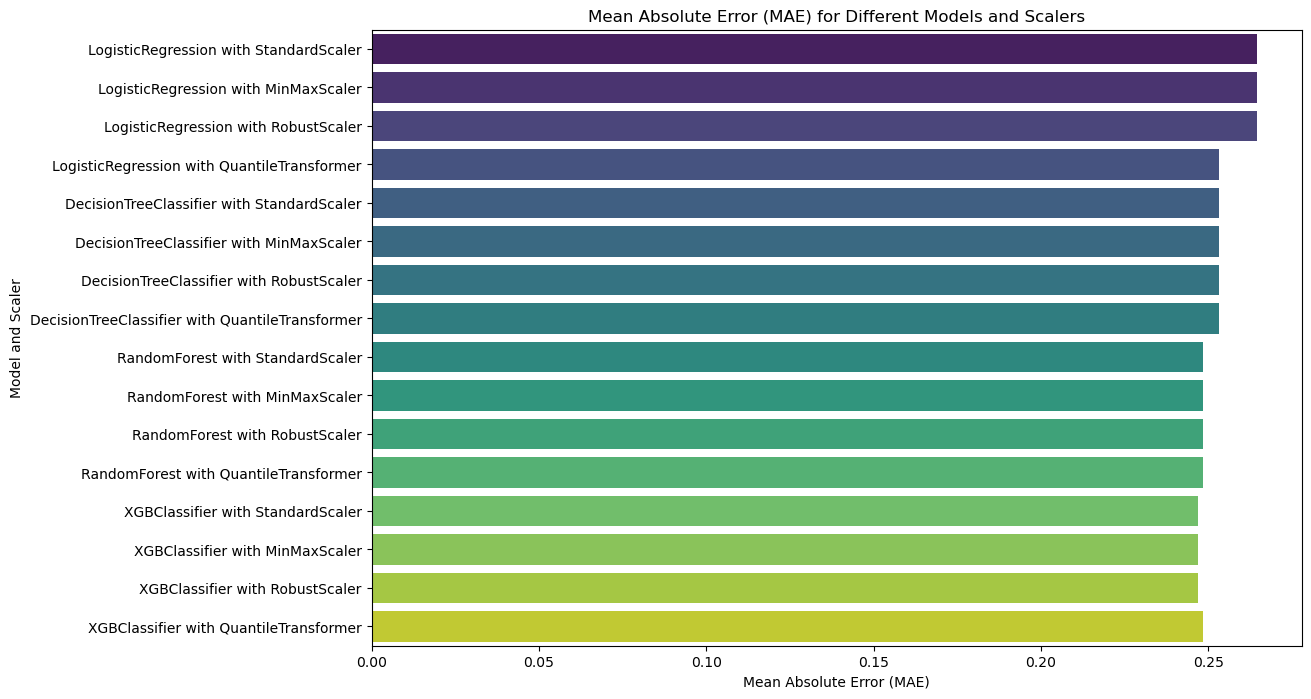

In [310]:
import matplotlib.pyplot as plt
import seaborn as sns

# Tracer un graphique de barres pour la MAE
plt.figure(figsize=(12, 8))
sns.barplot(x='mae', y=results_df.index, data=results_df, palette='viridis')
plt.title('Mean Absolute Error (MAE) for Different Models and Scalers')
plt.xlabel('Mean Absolute Error (MAE)')
plt.ylabel('Model and Scaler')
plt.show()


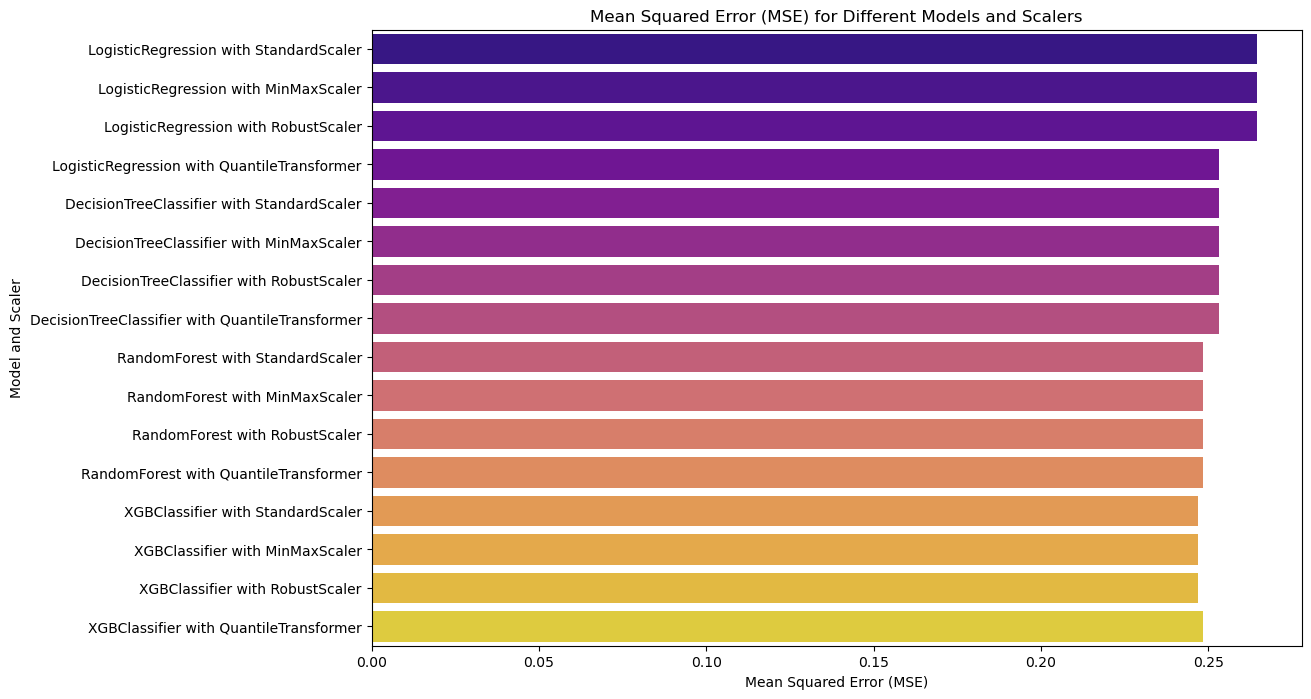

In [311]:
# Tracer un graphique de barres pour la MSE
plt.figure(figsize=(12, 8))
sns.barplot(x='mse', y=results_df.index, data=results_df, palette='plasma')
plt.title('Mean Squared Error (MSE) for Different Models and Scalers')
plt.xlabel('Mean Squared Error (MSE)')
plt.ylabel('Model and Scaler')
plt.show()


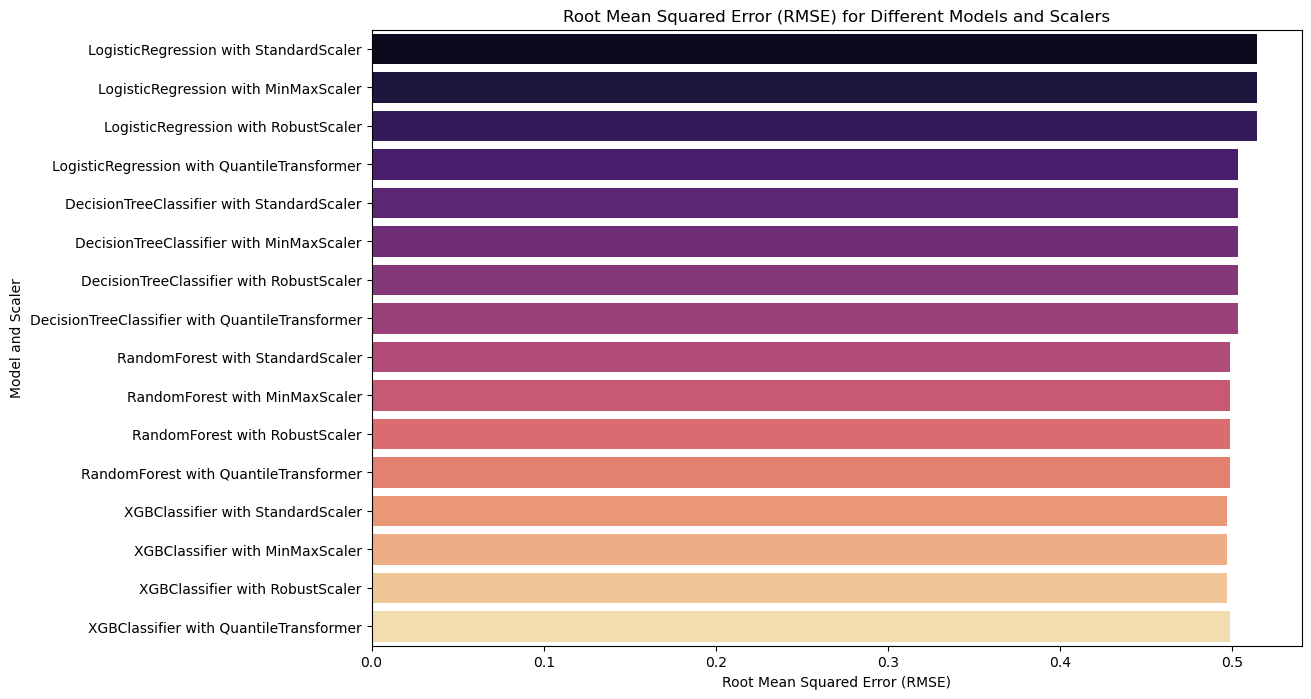

In [312]:
# Tracer un graphique de barres pour la RMSE
plt.figure(figsize=(12, 8))
sns.barplot(x='rmse', y=results_df.index, data=results_df, palette='magma')
plt.title('Root Mean Squared Error (RMSE) for Different Models and Scalers')
plt.xlabel('Root Mean Squared Error (RMSE)')
plt.ylabel('Model and Scaler')
plt.show()

## Conclusion, meilleurs modèles : 
    - XGBoost, RandomForest, DecisionTreeClassifier,  
    - choix fait suite aux résultats obtenus pour la meilleur métrique : MSA. 
    - le scaler standard est suffisant        

In [367]:
X = df[col_name]
y = df['si2014']
temp = X.drop(columns = 'abb14_renewed')
X_def = temp.drop(columns = 'codcliente')

scaler = StandardScaler()
# Appliquer le scaler aux données d'entraînement
X_scaled_best = scaler.fit_transform(X_def)

In [373]:
models = {
    'LogisticRegression' : LogisticRegression(penalty = 'l2', C = 162.3776739188721, solver = 'liblinear'),
    'DecisionTreeClassifier' : DecisionTreeClassifier(criterion = 'entropy', max_depth = 8, min_samples_leaf = 4, min_samples_split = 2, splitter = 'best',random_state=42),
    'RandomForest' : RandomForestClassifier(n_estimators=111, criterion='entropy', max_depth=10, min_samples_split=2, min_samples_leaf=4, max_features=None, random_state=42),
    'XGBClassifier' : XGBClassifier(n_estimators = 281, max_depth = 2, learning_rate = 0.1761911094046562, use_label_encoder=False)
}

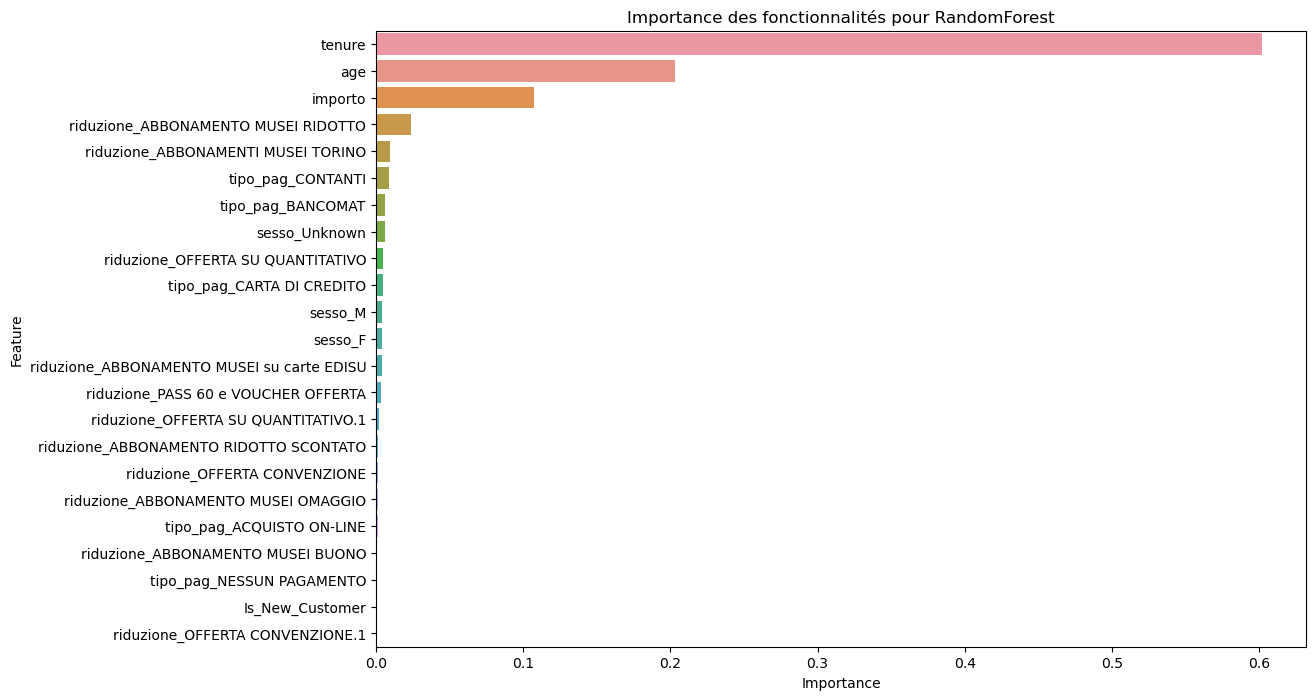

In [384]:
forest = models['RandomForest']

forest.fit(X_scaled_best, y)

# Obtenir l'importance des fonctionnalités
feature_importances = forest.feature_importances_

# Créer un DataFrame pour visualiser l'importance des fonctionnalités
feature_importance_df = pd.DataFrame({'Feature': X_def.columns, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Tracer l'importance des fonctionnalités
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Importance des fonctionnalités pour RandomForest')
plt.show()

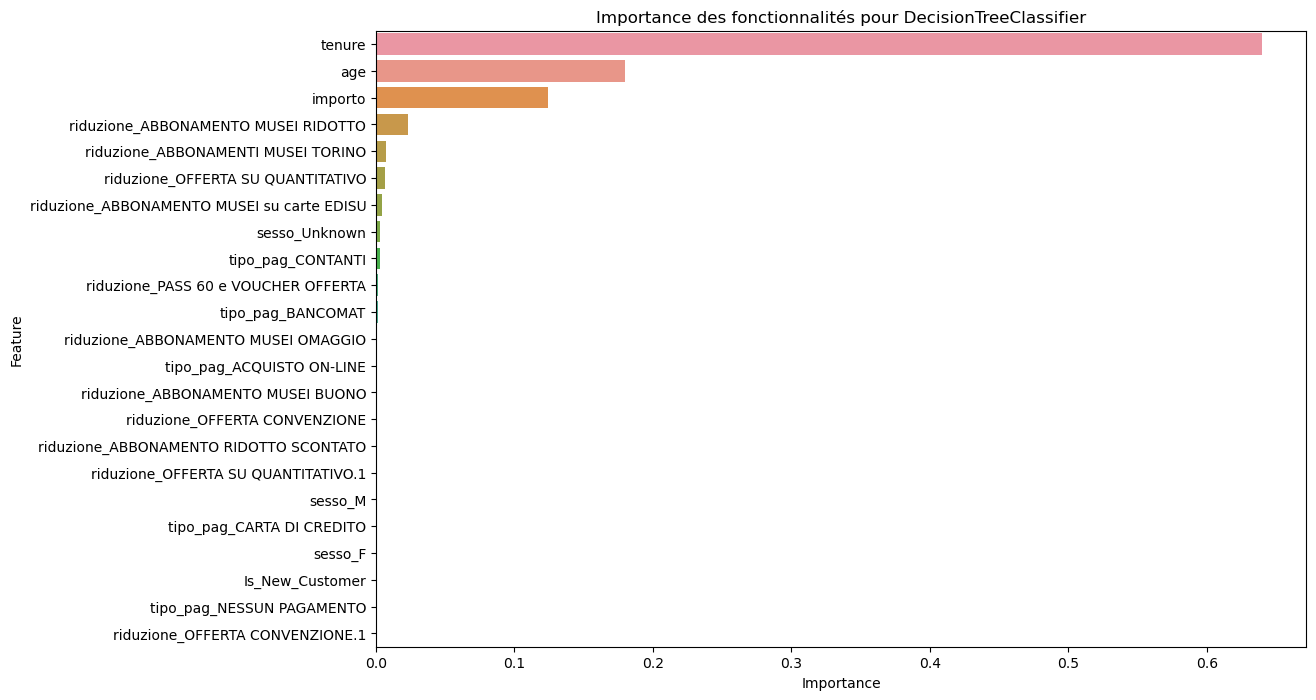

In [386]:
# Sélectionner le modèle DecisionTreeClassifier
tree = models['DecisionTreeClassifier']

# Adapter le modèle sur l'ensemble des données
tree.fit(X_scaled_best, y)

# Obtenir l'importance des fonctionnalités
feature_importances = tree.feature_importances_

# Créer un DataFrame pour visualiser l'importance des fonctionnalités
feature_importance_df = pd.DataFrame({'Feature': X_def.columns, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Tracer l'importance des fonctionnalités
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Importance des fonctionnalités pour DecisionTreeClassifier')
plt.show()

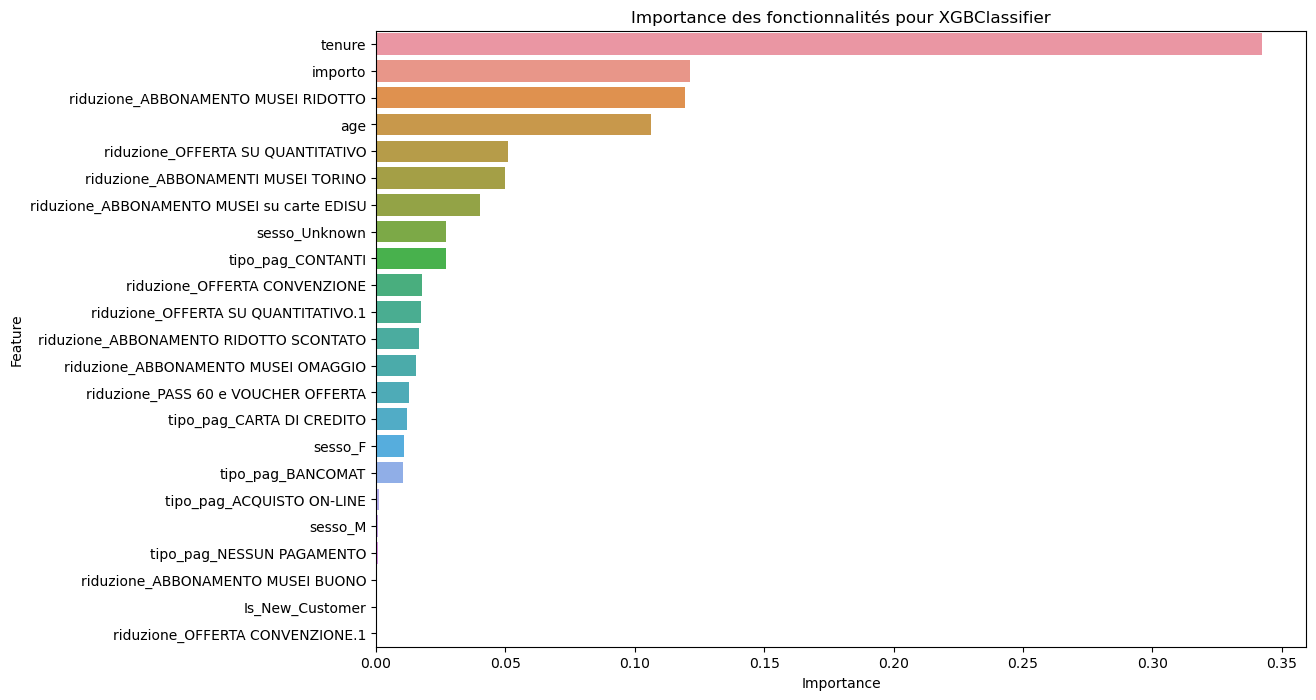

In [388]:
# Sélectionner le modèle XGBClassifier
Xgb = models['XGBClassifier']

# Adapter le modèle sur l'ensemble des données
Xgb.fit(X_scaled_best, y)

# Obtenir l'importance des fonctionnalités
feature_importances = Xgb.feature_importances_

# Créer un DataFrame pour visualiser l'importance des fonctionnalités
feature_importance_df = pd.DataFrame({'Feature': X_def.columns, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Tracer l'importance des fonctionnalités
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Importance des fonctionnalités pour XGBClassifier')
plt.show()


In [190]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

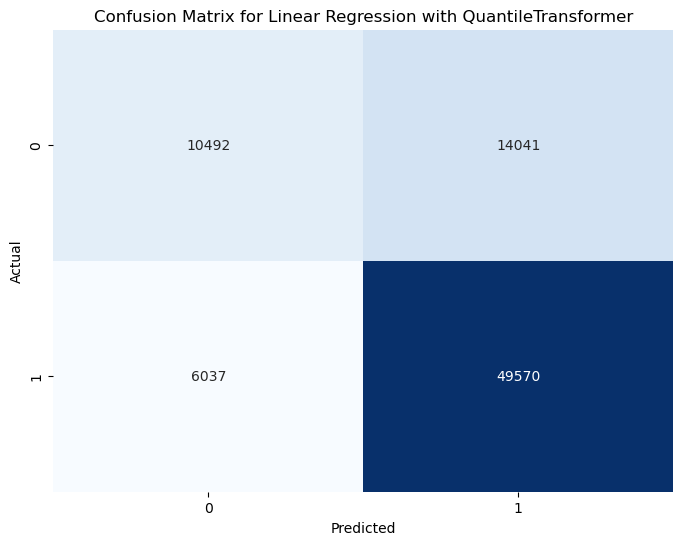

Accuracy: 74.95%


In [363]:
# Sélectionner le meilleur modèle de classification
best_classification_model = models[0][1]

X = df[col_name]
y = df['si2014']
temp = X.drop(columns = 'abb14_renewed')
X_def = temp.drop(columns = 'codcliente')

# Appliquer le meilleur scaler aux données
scaler = QuantileTransformer()
X_scaled_best = scaler.fit_transform(X_def)

# Adapter le meilleur modèle sur l'ensemble des données
best_classification_model.fit(X_scaled_best, y)

# Prédire les classes avec validation croisée
y_pred_best_classes = cross_val_predict(best_classification_model, X_scaled_best, y, cv=5)

# Obtenir la matrice de confusion
conf_matrix = confusion_matrix(y, y_pred_best_classes)

# Tracer la matrice de confusion
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix for Linear Regression with QuantileTransformer')
plt.show()


# Calculer et afficher la précision
accuracy = accuracy_score(y, y_pred_best_classes)
print(f"Accuracy: {accuracy:.2%}")

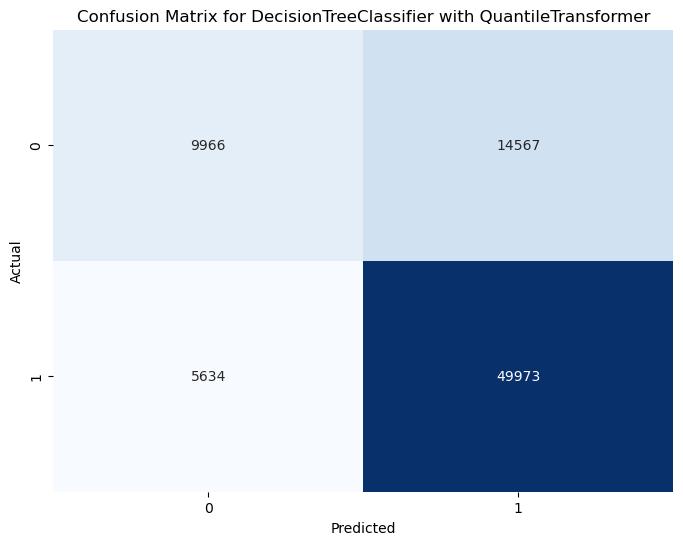

Accuracy: 74.79%


In [364]:
best_classification_model = models[1][1]

X = df[col_name]
y = df['si2014']
temp = X.drop(columns = 'abb14_renewed')
X_def = temp.drop(columns = 'codcliente')

# Appliquer le meilleur scaler aux données
scaler = QuantileTransformer()
X_scaled_best = scaler.fit_transform(X_def)

# Adapter le meilleur modèle sur l'ensemble des données
best_classification_model.fit(X_scaled_best, y)

# Prédire les classes avec validation croisée
y_pred_best_classes = cross_val_predict(best_classification_model, X_scaled_best, y, cv=5)

# Obtenir la matrice de confusion
conf_matrix = confusion_matrix(y, y_pred_best_classes)

# Tracer la matrice de confusion
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix for DecisionTreeClassifier with QuantileTransformer')
plt.show()


# Calculer et afficher la précision
accuracy = accuracy_score(y, y_pred_best_classes)
print(f"Accuracy: {accuracy:.2%}")

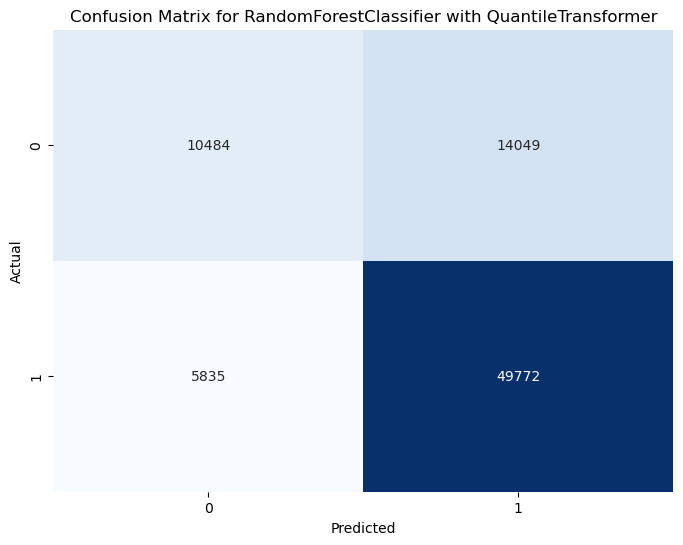

Accuracy: 75.19%


In [365]:
best_classification_model = models[2][1]

X = df[col_name]
y = df['si2014']
temp = X.drop(columns = 'abb14_renewed')
X_def = temp.drop(columns = 'codcliente')

# Appliquer le meilleur scaler aux données
scaler = QuantileTransformer()
X_scaled_best = scaler.fit_transform(X_def)

# Adapter le meilleur modèle sur l'ensemble des données
best_classification_model.fit(X_scaled_best, y)

# Prédire les classes avec validation croisée
y_pred_best_classes = cross_val_predict(best_classification_model, X_scaled_best, y, cv=5)

# Obtenir la matrice de confusion
conf_matrix = confusion_matrix(y, y_pred_best_classes)

# Tracer la matrice de confusion
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix for RandomForestClassifier with QuantileTransformer')
plt.show()


# Calculer et afficher la précision
accuracy = accuracy_score(y, y_pred_best_classes)
print(f"Accuracy: {accuracy:.2%}")

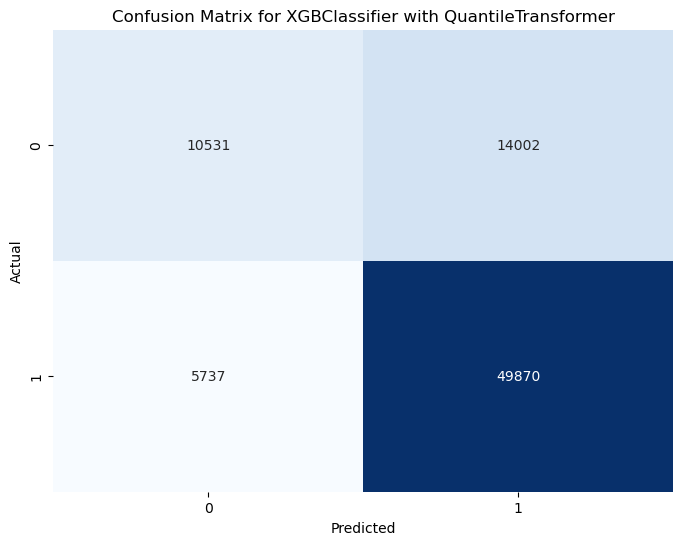

Accuracy: 75.37%


In [366]:
# Sélectionner le meilleur modèle de classification
best_classification_model = models[3][1]

X = df[col_name]
y = df['si2014']
temp = X.drop(columns = 'abb14_renewed')
X_def = temp.drop(columns = 'codcliente')

# Appliquer le meilleur scaler aux données
scaler = QuantileTransformer()
X_scaled_best = scaler.fit_transform(X_def)

# Adapter le meilleur modèle sur l'ensemble des données
best_classification_model.fit(X_scaled_best, y)

# Prédire les classes avec validation croisée
y_pred_best_classes = cross_val_predict(best_classification_model, X_scaled_best, y, cv=5)

# Obtenir la matrice de confusion
conf_matrix = confusion_matrix(y, y_pred_best_classes)

# Tracer la matrice de confusion
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix for XGBClassifier with QuantileTransformer')
plt.show()


# Calculer et afficher la précision
accuracy = accuracy_score(y, y_pred_best_classes)
print(f"Accuracy: {accuracy:.2%}")

# Courbe ROC

AUC (LogisticRegression) --> 76.04168%
AUC (DecisionTreeClassifier) --> 78.11057%
AUC (RandomForest) --> 78.83820%
AUC (XGBClassifier) --> 78.77111%


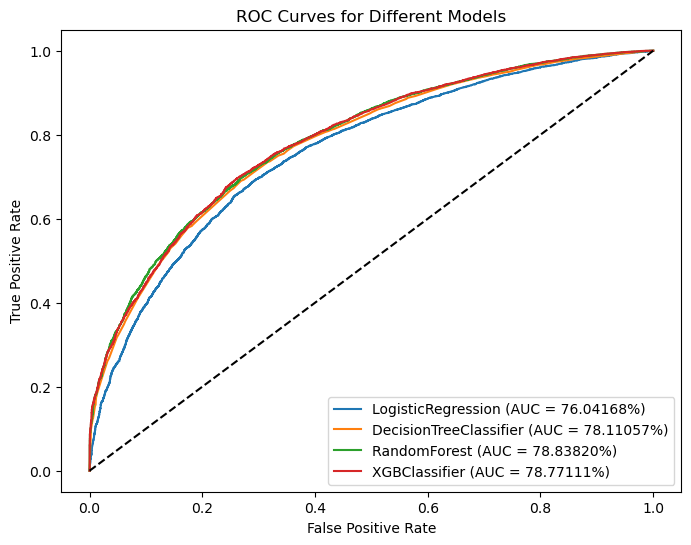

In [336]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

X = df[col_name]
y = df['si2014']
temp = X.drop(columns = 'abb14_renewed')
X_def = temp.drop(columns = 'codcliente')

fpr_tpr_dict = {}

plt.figure(figsize=(8, 6))

# Boucle sur les modèles
for model_name, model_instance in models:
    X_train, X_test, y_train, y_test = train_test_split(X_def, y, test_size=0.2, random_state=42)

    model_instance.fit(X_train, y_train)
    
    # Prédire sur les données de test
    prediction_prob = model_instance.predict_proba(X_test)[:, 1]
    
    # Calcul des mesures de performance (AUC)
    auc = roc_auc_score(y_test, prediction_prob)
    print(f"AUC ({model_name}) --> {auc * 100:.5f}%")

    # Calcul des courbes ROC pour chaque modèle
    fpr, tpr, _ = roc_curve(y_test, prediction_prob)
    
    # Enregistrer FPR et TPR dans un dictionnaire
    fpr_tpr_dict[model_name] = (fpr, tpr)
    
# Affichage des courbes ROC pour chaque modèle
for model_name, (fpr, tpr) in fpr_tpr_dict.items():
    auc = roc_auc_score(y_test, models[[m[0] for m in models].index(model_name)][1].predict_proba(X_test)[:, 1])
    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {auc * 100:.5f}%)")

# Affichage des courbes ROC pour les quatre modèles
plt.plot([0, 1], [0, 1], linestyle="--", color="black")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for Different Models")
plt.legend(loc='lower right')
plt.show()


# 2. Considérons une campagne de marketing s'adressant directement à des clients uniques. Nous savons que chaque contact coûte 0,2 euro et que chaque client peut être contacté. Lorsqu'un consommateur est contacté, il reçoit en cadeau une carte de musée gratuite pour l'année suivante. Faisons quelques hypothèses [FORTES] sur la valeur du consommateur : nous supposons que la valeur du consommateur est stable dans le temps et qu'elle correspond au prix payé plus 10 euros. Bien entendu, pour les personnes contactées qui ne sont pas des churners, il n'y a pas de gain, mais seulement un coût. À l'aide de ces informations supplémentaires, établissez une courbe de profit pour chaque modèle de prédiction. Tracez les courbes de profit des trois modèles et tirez-en des conclusions (70 points).

# Pour établir une courbe de profit pour chaque modèle de prédiction, nous pouvons utiliser les prédictions de chaque modèle pour estimer le gain et le coût associés à chaque prédiction, puis calculer le profit cumulatif en fonction du rang des prédictions.

In [67]:
col_name_df = ['codcliente',
 'abb14_renewed',
 'importo',
 'age',
 'tenure',
 'tipo_pag_ACQUISTO ON-LINE',
 'tipo_pag_BANCOMAT',
 'tipo_pag_CARTA DI CREDITO',
 'tipo_pag_CONTANTI',
 'tipo_pag_NESSUN PAGAMENTO',
 'Is_New_Customer',
 'sesso_F',
 'sesso_M',
 'sesso_Unknown',
 'riduzione_ABBONAMENTI MUSEI TORINO',
 'riduzione_ABBONAMENTO MUSEI BUONO',
 'riduzione_ABBONAMENTO MUSEI OMAGGIO',
 'riduzione_ABBONAMENTO MUSEI RIDOTTO',
 'riduzione_ABBONAMENTO MUSEI su carte EDISU',
 'riduzione_ABBONAMENTO RIDOTTO SCONTATO',
 'riduzione_OFFERTA CONVENZIONE',
 'riduzione_OFFERTA CONVENZIONE.1',
 'riduzione_OFFERTA SU QUANTITATIVO',
 'riduzione_OFFERTA SU QUANTITATIVO.1',
 'riduzione_PASS 60 e VOUCHER OFFERTA']


In [191]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import matplotlib.pyplot as plt

# données et modèles
models = [
    ('LogisticRegression', LogisticRegression(penalty='l2', C=162.3776739188721, solver='liblinear')),
    ('DecisionTreeClassifier', DecisionTreeClassifier(criterion='entropy', max_depth=8, min_samples_leaf=4, min_samples_split=2, splitter='best', random_state=42)),
    ('RandomForest', RandomForestClassifier(n_estimators=111, criterion='entropy', max_depth=10, min_samples_split=2, min_samples_leaf=4, max_features=None, random_state=42)),
    ('XGBClassifier', XGBClassifier(n_estimators=281, max_depth=2, learning_rate=0.1761911094046562, use_label_encoder=False))
]

X = df[col_name_df]
y = df['si2014']
temp = X.drop(columns='abb14_renewed')
X_def = temp.drop(columns='codcliente')

# Séparation des ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X_def, y, test_size=0.2, random_state=42)

# Initialisation des modèles
model_tree = models[1][1]
model_xgb = models[3][1]
model_rf = models[2][1]

# Coûts et gains
cost_per_contact = 0.2
gift_value = 10

# Entraînement des modèles
model_rf.fit(X_train, y_train)
roc_rf = model_rf.predict(X_test)

model_xgb.fit(X_train, y_train)
roc_xgb = model_xgb.predict(X_test)

model_tree.fit(X_train, y_train)
roc_tree = model_tree.predict(X_test)


def calculate_profit(y_test, X_def, gift_value, cost_per_contact):
    profit = []
    X_def.reset_index(drop=True, inplace=True)  # Réinitialiser l'index de X_def
    for i, observation in enumerate(y_test):
        if observation == 0:
            profit.append(gift_value - cost_per_contact)
        else:
            if i < len(X_def):  # Vérifier que l'index est valide pour X_def
                price_of_ticket = X_def['importo'].iloc[i]  # Utiliser iloc pour accéder par position après la réinitialisation de l'index
                profit.append(gift_value - price_of_ticket - cost_per_contact)
            else:
                profit.append(0)  # Remplacer par une valeur par défaut ou gérer autrement les indices non valides
    return profit



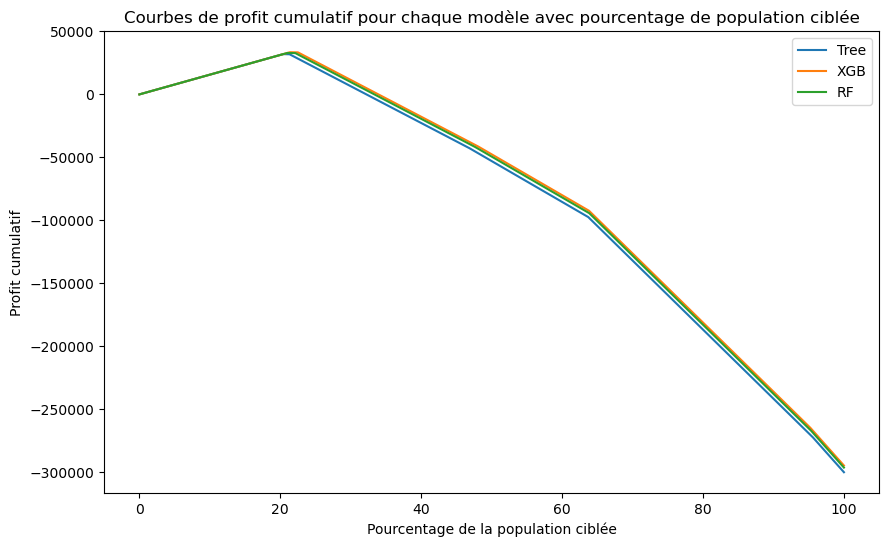

In [192]:
# Calcul des profits

profit_rf = calculate_profit(roc_rf, X_test, gift_value, cost_per_contact)
profit_xgb = calculate_profit(roc_xgb, X_test, gift_value, cost_per_contact)
profit_tree = calculate_profit(roc_tree, X_test, gift_value, cost_per_contact)

# Conversion des listes en Series pandas
profit_rf_series = pd.Series(profit_rf)
profit_tree_series = pd.Series(profit_tree)
profit_xgb_series = pd.Series(profit_xgb)

# Tri des profits dans l'ordre décroissant pour chaque modèle
profit_rf_sorted = profit_rf_series.sort_values(ascending=False).reset_index(drop=True)
profit_tree_sorted = profit_tree_series.sort_values(ascending=False).reset_index(drop=True)
profit_xgb_sorted = profit_xgb_series.sort_values(ascending=False).reset_index(drop=True)

# Calcul des profits cumulatifs pour chaque modèle
cumulative_profit_rf = profit_rf_sorted.cumsum()
cumulative_profit_tree = profit_tree_sorted.cumsum()
cumulative_profit_xgb = profit_xgb_sorted.cumsum()

# Calcul du pourcentage de la population ciblée en abscisse
population_percentage = np.linspace(0, 100, len(profit_rf))

# Tracer les courbes de profit cumulatif pour chaque modèle sur le même graphique
plt.figure(figsize=(10, 6))
plt.plot(population_percentage, cumulative_profit_tree, label='Tree')
plt.plot(population_percentage, cumulative_profit_xgb, label='XGB')
plt.plot(population_percentage, cumulative_profit_rf, label='RF')


plt.xlabel('Pourcentage de la population ciblée')
plt.ylabel('Profit cumulatif')
plt.legend()
plt.title('Courbes de profit cumulatif pour chaque modèle avec pourcentage de population ciblée')
plt.show()


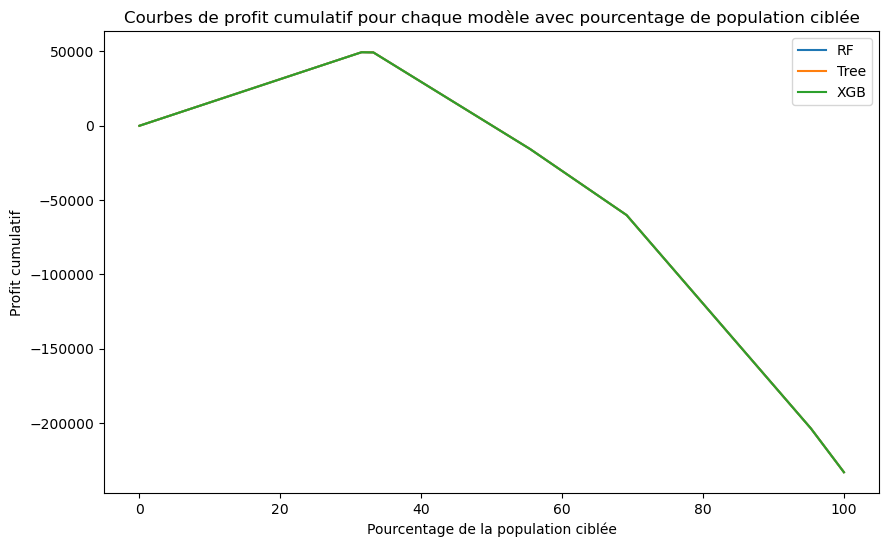

In [176]:
# Stocker les profits dans un DataFrame
profits = {
    'RF': profit_rf,
    'Tree': profit_tree,
    'XGB': profit_xgb
}
df_profits = pd.DataFrame(profits)

# Tri des profits dans l'ordre décroissant pour chaque modèle
df_profits = df_profits.apply(lambda col: col.sort_values(ascending=False).values)

# Calcul des profits cumulatifs pour chaque modèle
df_cumulative_profits = df_profits.cumsum()

# Calcul du pourcentage de la population ciblée en abscisse
population_percentage = np.linspace(0, 100, len(df_cumulative_profits))

# Tracer les courbes de profit cumulatif pour chaque modèle
plt.figure(figsize=(10, 6))
for col in df_cumulative_profits.columns:
    
    plt.plot(population_percentage, df_cumulative_profits[col], label=col)

plt.xlabel('Pourcentage de la population ciblée')
plt.ylabel('Profit cumulatif')
plt.legend()
plt.title('Courbes de profit cumulatif pour chaque modèle avec pourcentage de population ciblée')
plt.show()
